# 1 Patient Selection
Prior to this script it is important to extract the necessary data from HIX: 
- Run sql/GetReport_RA.sql to get the Conclusion section of all RA patients
- Run sql/GetAppointments_RA.sql to get the Conclusion section of all RA patients

Summary:
1. In this script we elucidate the first consult for each patient in HIX
2. We remove patients that were admitted before August 29, 2011 (because we cannot guarantee that we have all the data available)
3. We export / save different patient selections to be used in the proceeding research

In [1]:
import sys
sys.path.append(r'../src/1_emr_scripts')

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Gather all first consults
- SQL : Run GetAppointments_RA.sql to gather all first consults (financial code=NP) of the patients that visited the Rheumatology departement


## 1.2 Assess first visit date


In [1]:
import pandas as pd
import numpy as np

# Preload function
def getFirstPEC(pat):
    if pat in clean_dict.keys():
        return clean_dict[int(pat)]
    else :
        return np.nan

# import appointments 
df_rapp = pd.read_csv(r'../new_data/1_raw/Appointments_REU.csv', sep=";")

df_rapp['period_start_date'] = df_rapp['period_start_date'].apply(lambda x : pd.to_datetime(x, format='%d-%m-%Y', errors='ignore'))
df_rapp = df_rapp.sort_values(by='period_start_date')

print('Total Patients in HIX (with registered NP) :', len(df_rapp['subject_Patient_value'].unique()))

# Filter out visits prior to 2011
df_rapp = df_rapp[(df_rapp['period_start_date'] > pd.to_datetime('20110829', format='%Y%m%d', errors='ignore'))]

print('Patients with baseline after 2011 :', len(df_rapp['subject_Patient_value'].unique()))

Total Patients in HIX (with registered NP) : 45592
Patients with baseline after 2011 : 25821


#### #1.2.1 Write all patient ids in convenient format 

In [3]:
import math
l_pat = list(df_rapp['subject_Patient_value'].unique())

stepsize = 1000
with open('Pat_selection_sql.txt', 'w') as f:
    for j in range(int(math.ceil(float(len(l_pat)/stepsize)))):
        f.write('(' + '),('.join([str(int(i)) for i in l_pat[stepsize*j:stepsize*(j+1)]]) + ')\n')

## #1.3 Acquire Physician notes

- SQL : Run GetReport_RA.sql to gather all conclusion sections of the patients from the list of selected patients

## #1.4 Screen Physician notes
We will leverage the conclusion section of the DDR_A table (HIX) for our prediction of the RA diagnosis.



In [4]:
import pandas as pd
df_REUCON = pd.read_csv(r'../new_data/1_raw/processed_Notes_Entry.csv', sep="|", index_col=0)

# Only select patients after initialization of HIX (after 2011) 
df_REUCON = df_REUCON[df_REUCON['PATNR'].isin(l_pat)].copy()

# Save relevant selection
df_REUCON.to_csv(r'../new_data/1_raw/NewPatSelection_Notes_header.csv', sep=';', index=False) # 1 year
len(df_REUCON['PATNR'].unique())


/home/tdmaarseveen/.conda/envs/ra_clustering2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


24645

### #1.4.1 Prepare the consultation data

In [ ]:
import pandas as pd
import sys
sys.path.append(r'../src/1_emr_scripts')
import Preprocessing as func

d_first_date =df_rapp.groupby(['subject_Patient_value'])['period_start_date'].agg('max').to_dict()

df_REUCON = pd.read_csv(r'../new_data/1_raw/NewPatSelection_Notes_header.csv', sep=";")

df_REUCON['XANTWOORD'] = df_REUCON['XANTWOORD'].apply(lambda x : func.processArtefactsXML(str(x)))
df_REUCON['created'] =df_REUCON['created'].apply(lambda x: pd.to_datetime(x, utc=True, format='%Y-%m-%d', errors='ignore'))
df_REUCON = df_REUCON[df_REUCON['PATNR'].isin(d_first_date)]
df_REUCON['PEC'] = df_REUCON['PATNR'].apply(lambda x : d_first_date[x])

df_REUCON.head()

### #1.4.2 Aggregate Conclusion sections 

In [6]:
import Preprocessing as func
import pickle
import time

#model_name='savedModels/SVM.sav'
X_column='XANTWOORD'
y_column=""#'Outcome'
id_column='PATNR'

def entriesPatientMerge(pat_df, id_column, X_column, y_column=""):
    """
    Merges the entries into one entry per patient (according to the id_column)
    
    Input: 
        id_column = column with patient id
        X_column = column with 
    """
    field = ''
    for i in pat_df[X_column]:
        field += " " + i + " "
    if y_column!="":
        return {X_column: field, id_column : pat_df[id_column].iloc[0], y_column : pat_df[y_column].iloc[0]}
    else :
        return {X_column: field, id_column : pat_df[id_column].iloc[0]}

if y_column != "":
    df_ult = pd.DataFrame(columns=[X_column,  id_column, y_column])
else : 
    df_ult = pd.DataFrame(columns=[X_column,  id_column])
    
    
for pat in df_REUCON[id_column].unique():
    pat_df = df_REUCON[df_REUCON[id_column]==pat]
    if y_column != "":
        df_ult = df_ult.append(entriesPatientMerge(pat_df, id_column, X_column, y_column), ignore_index=True)
    else : 
        df_ult = df_ult.append(entriesPatientMerge(pat_df, id_column, X_column), ignore_index=True)

df_ult=df_ult.fillna('')
df_ult['XANTWOORD'] = df_ult['XANTWOORD'].apply(lambda x : func.processArtefactsXML(str(x)))

df_ult.to_csv(r'../new_data/1_raw/processed_Notes_Total.csv', sep='|') # 1 year

## #1.5 Apply ML

In [7]:
import pickle
import time
import sklearn

df_ult =  pd.read_csv(r'../new_data/1_raw/processed_Notes_Total.csv', sep='|') 
df_ult = df_ult.fillna('')

# get EMR text
text_column = 'XANTWOORD'
X = df_ult[text_column].values

# apply built model on provided text
loaded_model = pickle.load(open(r'../models/SVM_20221201_ALL.sav', 'rb')) # SVM_20221201  SVM_29042020.sav

t0 = time.time()

probas_ = loaded_model.predict_proba(X)
pred = probas_[:,1]

t1 = time.time()
print('Time for Making predictions (n=' + str(len(df_ult['PATNR'].unique())) + ') : ' + str(t1-t0))

# add predictions to table
df_ult['prediction'] = df_ult[text_column].copy()
df_ult['prediction'] = pred

# export predictions
df_ult[['PATNR', 'prediction', 'XANTWOORD']].to_csv(r'../new_data/1_raw/RA_patients_pred_3.csv', sep='|', index=False)

# export patient selection with corresponding text and subsequent predictions
df_ult[df_ult['prediction']>0.83][['PATNR', 'prediction', 'XANTWOORD']].to_csv(r'../new_data/1_raw/RA_patients_083_Total.csv', sep='|', index=False)


Time for Making predictions (n=24645) : 39.02286243438721


#### Check patients that reach the threshold

Threshold of 0.83 was defined in previous paper: https://arthritis-research.biomedcentral.com/articles/10.1186/s13075-021-02553-4  
The benefit of using this threshold is that it balances sensitivity and precision on 0.85

In [ ]:
df_ult[df_ult['prediction']>0.83]

## #1.6 Create new pseudoIds 
Create a composite identifier "pseudoId" by combining the patient id and the visit nr

We want to include all first Consults 

### #1.6.1 Select RA patients

In [9]:
l_found = df_ult[df_ult['prediction']>0.83]['PATNR'].unique()
print('Patients predicted to have RA :', len(l_found))
df_rapp = df_rapp[df_rapp['subject_Patient_value'].isin(l_found)]

Patients predicted to have RA : 2128


### #1.6.2 assign pseudoIds

Write down important patient info in a single table:
1. Pseudo Id
2. Date of first consult (or imputed)
3. Patient id
4. Visit number

In [ ]:
def create_dict_pseudoIds(df_rapp):
    """
    Create new pseudo ids for all first dates
    """
    new_pat = {}
    for pat in df_rapp['subject_Patient_value'].unique():
        cnt = 0
        sub_df = df_rapp[df_rapp['subject_Patient_value']==pat].copy()
        for index, row in sub_df.iterrows():
            identity = '%s_%s' % (pat, cnt)
            new_pat[identity] = pd.to_datetime(row['period_start_date'] , format='%d-%m-%Y', errors='ignore') 
            cnt += 1
    return new_pat

df_rapp = df_rapp[df_rapp['type1_code']!='NPSI'] # exclude patients that visit the 'InloopPoli'
new_pat = create_dict_pseudoIds(df_rapp)
df_pat = pd.DataFrame.from_dict(new_pat, orient='index')
df_pat = df_pat.reset_index()
df_pat.columns = ['pseudoId', 'date']
df_pat['patnr'] = df_pat['pseudoId'].apply(lambda x: x.split('_')[0])
df_pat['NP_visit_nr'] = df_pat['pseudoId'].apply(lambda x: x.split('_')[1])

# Remove patients with consultation before 2011
#df_pat = df_pat[df_pat['period_start_date'] > pd.to_datetime('20110829', format='%Y%m%d', errors='ignore')]

# Export
df_pat.to_csv('../filters/RA_patients_AllNP_11-10-2022.csv')
df_pat.head()

### #1.6.3 Visualize number of 'first' visits per patient 

[1, 2, 3, 4, 5] [1654, 394, 69, 8, 2]


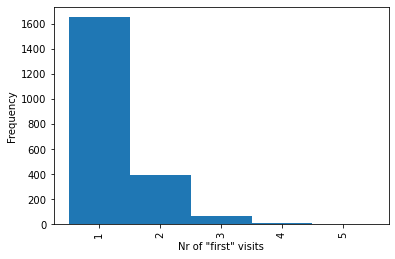

In [11]:
## Create new id system
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
df_symptom = pd.DataFrame.from_dict(dict(Counter(list(Counter(df_rapp['subject_Patient_value']).values())).items()), orient='index').sort_index()

labels, values = list(range(1, len(df_symptom)+1)), list(df_symptom[0])
print(labels, values)

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes , labels, rotation=90)
plt.xlabel('Nr of "first" visits')
plt.ylabel('Frequency')
plt.show()

### #1.6.4 Export all patient ids for SQL queries

We will create a copy of all identified patients. This list will be used to query clinical data from the SQL database. The data is formatted in a convenient structure for SQL.

In [12]:
stepsize = 1000
with open('../keys/HIX_RA_selection.txt', 'w') as f:
    for j in range(int(math.ceil(float(len(l_found)/stepsize)))):
        f.write('(' + '),('.join([str(int(i)) for i in l_found[stepsize*j:stepsize*(j+1)]]) + ')\n')